# Lyrics cleaning and analysis

### Find instructions here for nltk use (https://github.com/johnwmillr/LyricsGenius/blob/master/README.md)

In [1]:
# #Install lyrics genius module
# !pip install lyricsgenius

In [2]:
# ## Natural Language Toolkit (NLTK) is a Python package for natural language processing
# ## Install nltk module (for info: https://www.nltk.org/data.html) *takes a while to download*
# !pip install nltk

In [53]:
#Import module and config with token

#for API calls
import requests
import pandas as pd
from pprint import pprint

#for genius.com
import lyricsgenius
from config import genius_token
genius = lyricsgenius.Genius(genius_token)

# #for nlkt (remove stop words)    ---> all available datasets/models:CORPORA: http://www.nltk.org/nltk_data/
# import nltk
# nltk.download("stopwords")   #can install the “popular” subset of NLTK data, stopwords is included
from nltk.corpus import stopwords 

# for punctuation, import string library function  
import string  

#for plotting
import matplotlib.pyplot as plt

#for stats
import scipy.stats as stats


In [4]:
#RUN WHEN LIST OF SONGS IS AVAILABLE

#Open file with songs from top populated eras
song_with_lyrics_df=pd.read_csv("csv/song_with_lyrics.csv")

# #Drop weird column created for don't know what reason
weird_columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1"]
song_list_df=song_with_lyrics_df.drop(weird_columns, axis=1)


song_list_df.head(15)

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins
0,2,The Scientist,Coldplay,309,A Rush of Blood to the Head,"[Verse 1]\nCome up to meet you, tell you I'm s...",2002,2000s
1,3,Yellow,Coldplay,267,Parachutes,[Verse 1: Chris Martin]\nLook at the stars\nLo...,2000,2000s
2,4,Fix You,Coldplay,294,X&Y,[Verse 1: Chris Martin]\nWhen you try your bes...,2005,2000s
3,5,Chasing Cars,Snow Patrol,0,Eyes Open,[Verse 1]\nWe'll do it all\nEverything\nOn our...,2006,2000s
4,7,I'm Yours,Jason Mraz,242,I'm Yours,"[Verse 1]\nWell, you done done me, and you bet...",2008,2000s
5,8,I Will Follow You Into The Dark,Death Cab for Cutie,0,Plans,"[Verse 1]\nLove of mine, someday you will die\...",2006,2000s
6,9,How to Save a Life,The Fray,290,How to Save a Life,"[Verse 1]\nStep one, you say we need to talk\n...",2005,2000s
7,11,She Will Be Loved,Maroon 5,379,Songs About Jane,[Verse 1]\nBeauty queen of only eighteen\nShe ...,2002,2000s
8,12,Such Great Heights,The Postal Service,262,Give Up,[Verse 1]\nI am thinking it's a sign\nThat the...,2003,2000s
9,13,Skinny Love,Bon Iver,239,"For Emma, Forever Ago","[Verse 1]\nCome on, skinny love, just last the...",2007,2000s


In [5]:
#Check for duplicates in the list of songs
duplicates=song_list_df.duplicated(subset=["Song Name", "Artist"], keep=False)
song_list_df[duplicates]

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins


## Cleaning lyrics
* stop words (a, about, above, after, again, against, all....)
* punctuation characters (. ; : [] ? ...)
* words related to song structure (intro, chorus, verse)
* numbers

In [6]:
#Split lyrics into words, create a new df

#punctuation= [',', '.', ';', ':', '[', ']', '?', '!', '(', ')', '"', '%', "&", "-", "--"]  #old punctuation
punctuation=list(string.punctuation)

#(for info: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)
stop_words= set(stopwords.words('english')) 

#possible verse number (as strings)
numbers=[str(n) for n in range(100)]

#possible song structure terms and artist names
song_structure_words=["intro", "verse", "chorus", "bridge", "outro", "hook"]  #"chris", "martin", 

#list of total words, unique words (arrays) and unique_word_counts (series)
tot_words_list=[]            #list of total number of words per song
unique_words_list=[]         #list of unique words per song
unique_words_count_list=[]   #list of count of unique words per song


for index, row in song_list_df.iterrows():
    
    #Store song lyrics in a variable
    song_lyrics=song_list_df["Lyrics"][index]

    #Before splitting lyrics into words, remove punctation characters
    song_lyrics_clean= song_lyrics

    for x in punctuation:
        if not x == "'":
            song_lyrics_clean=song_lyrics_clean.replace(x,"")

    #Split string into list of words
    words_list= song_lyrics_clean.split() 

    #Make df of lowercase words (stop words are all lowercase)
    words_list_lower=[words_list[x].lower() for x in range(len(words_list))]

    #Remove stop words such as “the”, “a”, “an”, “in” 
    filtered_1=[k for k in words_list_lower if not k in stop_words]

    #remove possible verse number (as strings)
    filtered_2=[k for k in filtered_1 if not k in numbers] 

    #remove song structure words     
    filtered_lyrics_index=[k for k in filtered_2 if not k in song_structure_words] 
    
    #Create a df for lyrics analysis
    lyrics_index_df=pd.DataFrame()
 
    #Save song_lyrics_clean to a new dataframe
    lyrics_index_df[index]=filtered_lyrics_index
    
    #Number of words
    tot_words=len(lyrics_index_df[index])
    tot_words_list.append(tot_words)
    
    #Unique words
    unique_words=lyrics_index_df[index].unique()
    unique_words_list.append(unique_words)
    
    #Count of Unique words
    unique_words_count=lyrics_index_df[index].value_counts()
    unique_words_count_list.append(unique_words_count)    
    
    
#     #Rename column and export to csv as lyrics_index.csv
#     column_name= f'{song_list_df["Song Name"][index]}_{song_list_df["Artist"][index]}'
#     lyrics_index_df=lyrics_index_df.rename(columns={index: column_name})
#     lyrics_index_df.to_csv(f'Lyrics/lyrics_{index}_df.csv')

lyrics_index_df

,1109
0,love
1,tragic
2,love
3,bold
4,always
...,...
73,could
74,handle
75,life
76,can't


In [7]:
#list of total words for each song
tot_words_list

[101,
 99,
 93,
 83,
 227,
 110,
 166,
 144,
 123,
 76,
 125,
 134,
 408,
 150,
 119,
 231,
 86,
 152,
 49,
 80,
 152,
 110,
 125,
 100,
 61,
 87,
 215,
 240,
 73,
 122,
 168,
 43,
 65,
 72,
 48,
 214,
 154,
 168,
 109,
 91,
 116,
 103,
 91,
 202,
 52,
 87,
 104,
 70,
 53,
 130,
 87,
 156,
 150,
 134,
 146,
 105,
 181,
 365,
 146,
 193,
 83,
 95,
 255,
 99,
 151,
 256,
 179,
 95,
 142,
 136,
 163,
 110,
 84,
 86,
 118,
 232,
 99,
 281,
 111,
 41,
 300,
 267,
 269,
 200,
 141,
 102,
 126,
 72,
 74,
 138,
 60,
 100,
 108,
 97,
 130,
 118,
 75,
 141,
 168,
 143,
 101,
 61,
 129,
 394,
 102,
 57,
 103,
 99,
 110,
 441,
 158,
 129,
 96,
 93,
 60,
 82,
 385,
 106,
 86,
 144,
 126,
 118,
 63,
 139,
 102,
 129,
 170,
 76,
 250,
 82,
 112,
 120,
 171,
 101,
 314,
 43,
 129,
 133,
 183,
 130,
 162,
 159,
 65,
 82,
 129,
 80,
 235,
 207,
 184,
 94,
 123,
 132,
 75,
 250,
 28,
 118,
 117,
 184,
 111,
 142,
 88,
 136,
 106,
 77,
 180,
 59,
 97,
 160,
 92,
 157,
 129,
 101,
 125,
 161,
 101,
 139,
 

In [8]:
#list of unique words for each song
unique_words_list

[array(['come', 'meet', 'tell', "i'm", 'sorry', 'know', 'lovely', 'find',
        'need', 'set', 'apart', 'secrets', 'ask', 'questions', 'oh',
        "let's", 'go', 'back', 'start', 'running', 'circles', 'coming',
        'tails', 'heads', 'science', 'nobody', 'said', 'easy', 'shame',
        'us', 'part', 'one', 'ever', 'would', 'hard', 'take', 'guessing',
        'numbers', 'figures', 'pulling', 'puzzles', 'progress', 'speak',
        'loud', 'heart', 'love', 'haunt', 'rush', 'chasing', 'going',
        'ohooh', 'oohoohoohooh', 'aahooh'], dtype=object),
 array(['chris', 'martin', 'look', 'stars', 'shine', 'everything', 'yeah',
        'yellow', 'came', 'along', 'wrote', 'song', 'things', 'called',
        'took', 'turn', 'oh', 'thing', 'done', 'jonny', 'aah', 'skin',
        'bones', 'ooh', 'something', 'beautiful', 'know', 'love', 'swam',
        'across', 'jumped', "'cause", 'drew', 'line', "i'd", 'bleed',
        'dry', 'true'], dtype=object),
 array(['chris', 'martin', 'try', 'b

In [9]:
#list of unique words counts for each song
unique_words_count_list

[said            6
 tell            5
 back            5
 oohoohoohooh    4
 start           4
 nobody          4
 oh              4
 easy            4
 science         3
 ohooh           3
 apart           3
 us              2
 circles         2
 part            2
 tails           2
 questions       2
 i'm             2
 one             2
 ever            2
 come            2
 would           2
 hard            2
 running         2
 coming          2
 shame           2
 aahooh          1
 take            1
 love            1
 rush            1
 set             1
 speak           1
 lovely          1
 pulling         1
 heads           1
 go              1
 haunt           1
 know            1
 figures         1
 meet            1
 ask             1
 puzzles         1
 secrets         1
 chasing         1
 find            1
 guessing        1
 sorry           1
 going           1
 progress        1
 heart           1
 need            1
 numbers         1
 let's           1
 loud       

# ANALYSIS: Word count per era

In [28]:
#Create a new df with year, bin categoty and word count list
words_count_df=pd.DataFrame({
    "Song Name": song_list_df["Song Name"],
    "Artist": song_list_df["Artist"],
    "Words count": tot_words_list,
    "Year": song_list_df["Year"],
    "Bin": song_list_df["bins"]
})

words_count_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,101,2002,2000s
1,Yellow,Coldplay,99,2000,2000s
2,Fix You,Coldplay,93,2005,2000s
3,Chasing Cars,Snow Patrol,83,2006,2000s
4,I'm Yours,Jason Mraz,227,2008,2000s
...,...,...,...,...,...
1105,Hard to Say I'm Sorry,Chicago,96,1983,80s
1106,Haunted,Taylor Swift,172,2010,2010s
1107,Breakthrough,Modest Mouse,118,1996,90s
1108,Saturday Night,Misfits,124,1999,90s


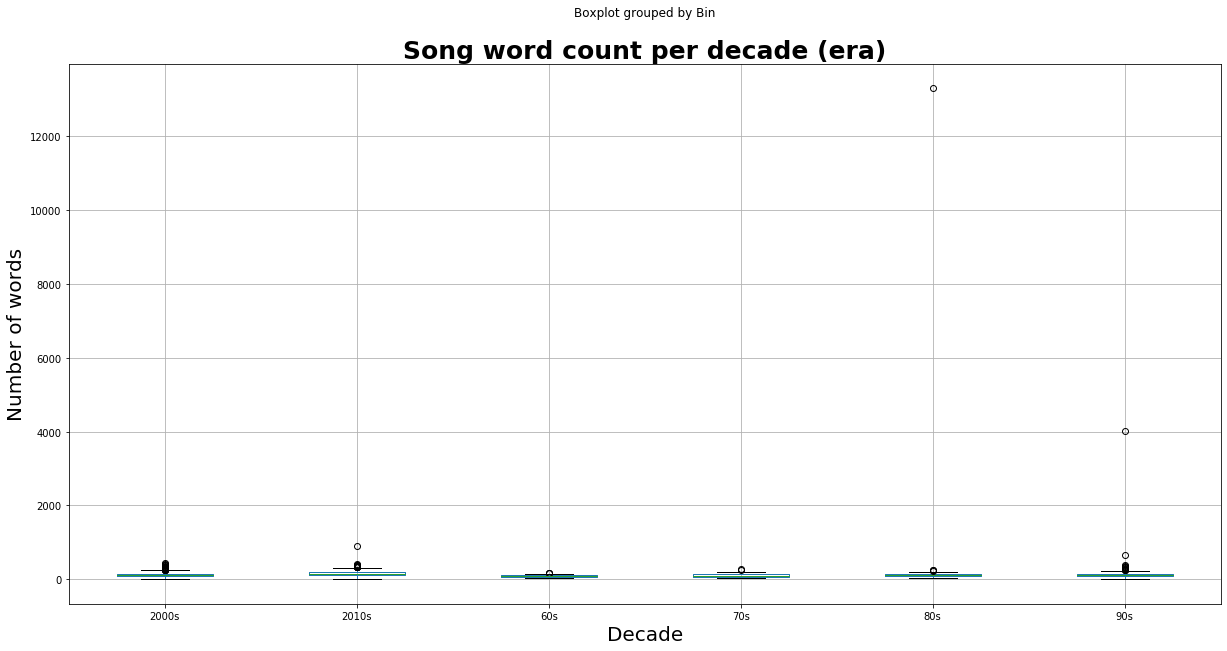

In [47]:
#Plot
words_count_df.boxplot("Words count", by="Bin", figsize=(20,10))
plt.title("Song word count per decade (era)", fontsize=25, fontweight="bold")
plt.xlabel("Decade", fontsize=20)
plt.ylabel("Number of words", fontsize=20)
plt.savefig("Plots/word_count_boxplot_original.png")

In [30]:
#Identify outliers from words_count_df with number of words >2000
outliers=words_count_df.loc[words_count_df["Words count"] > 2000]
outliers

,Song Name,Artist,Words count,Year,Bin
753,Everybody's Gotta Learn Sometimes,Beck,4023,1999,90s
1022,shhh.. Just listEn :),A Rocket to the Moon,13288,1988,80s


In [31]:
#Retrieve info for outliers in song_list_df
outliers_df=song_list_df.loc[(song_list_df.index == 753) | (song_list_df.index == 1022)]
outliers_df

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins
753,993,Everybody's Gotta Learn Sometimes,Beck,354,Cinematic Treatment,[Verse 1]\nSometimes you can fix something by ...,1999,90s
1022,774,shhh.. Just listEn :),A Rocket to the Moon,0,NaN,"FADE IN:\n\nEXT. WINTER RIVER, CONNECTICUT - D...",1988,80s


### Check outliers lyrics

In [33]:
#A Rocket to the Moon - shhh.. Just listEn :)
outliers_df["Lyrics"][1022]

#Comment: A lot info in the lyrics, like " CAMERA EXPLORES, ATTIC - NEW ANGLE - DAY" -----> DROP!

'FADE IN:\n\nEXT. WINTER RIVER, CONNECTICUT - DAY\n\nA crisp and perfect New England town.  Almost too neat\nto be real.  No visible townspeople.  CAMERA EXPLORES\ntown.\n\n\nCAMERA FLIES\n\nover a rickety bridge -- PAST the Maitland Hardware and\nAppliance store -- PAST the church -- the Historical\nSociety -- UP over the graveyard on the hill and\nfinally --\n\nTo the Maitland house.  The perfect Victorian house\nsurveying the tiny village.  Suddenly --\n\n\nA GIANT DADDY LONGLEGS SPIDER\n\nmounts the crest of the hill beside the house, pauses to\nwave a spindly leg and then creeps menacingly on top of\nthe Maitland house.\n\nADAM (O.S..)\nWell, well, you\'re a big fella...!\n\nA hand -- as big as God\'s -- with a huge tweezer,\ngently reaches down out of the sky and lies, palm up,\nin the yard next to the house.  Daddy Longlegs climbs\ninto it.  The hand rises into the sky again.\n\n\nINT. ATTIC - NEW ANGLE - DAY\n\nReveals Winter River as a miniature town, while The\nDaddy Longlegs

In [34]:
#Beck - Everybody's Gotta Learn Sometimes
outliers_df["Lyrics"][753]

#Comment: the song does exist but the lyrics belong to another song (Genius problem) (The Devil Glitch by Chris Butler\
#also known as the longest song ever! Full version is 1h long. https://www.youtube.com/watch?v=10SnNfxjAI8)  -----> DROP!

'[Verse 1]\nSometimes you can fix something by just being a prick\nWinning by intimidation\n\n[Verse 2]\nSometimes you can fix something by just lifting your skirt\nIt\'s the ultimate distraction\n\n[Verse 3]\nI poke button\nI want action\nLet\'s hear some gears and see some smoke\nNo dilly-dally\nMove your heinie\nThis is the age of "go for broke"\n\n[Screw It, There Are 500 Verses, I Don\'t Have Time For This]\nSometimes you can fix something by just kissing some ass\nIf you don\'t mind humiliation\nSometimes you can fix something by just smoking a pipe\nAcademic contemplation\n\n\n\nSo pathetic\n\nNo mechanic\n\nNo steady eye, no magic touch\n\nNo screwdriver\n\nBall-peen hammer\n\nAnd Mr. Fix-it\'s gone to lunch\n\n\n\nNot personal?\n\nYeah it\'s personal\n\nWhat did I ever do to you?\n\nNo crap from\n\nContraptions\n\nJust do what I tell you to do\n\n\n\nSometimes you can fix something by just blaming your mom\n\nEverybody loves a victim\n\nSometimes you can fix something by just 

In [35]:
#Drop outliers
words_count_clean_df=words_count_df.drop([753, 1022])
words_count_clean_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,101,2002,2000s
1,Yellow,Coldplay,99,2000,2000s
2,Fix You,Coldplay,93,2005,2000s
3,Chasing Cars,Snow Patrol,83,2006,2000s
4,I'm Yours,Jason Mraz,227,2008,2000s
...,...,...,...,...,...
1105,Hard to Say I'm Sorry,Chicago,96,1983,80s
1106,Haunted,Taylor Swift,172,2010,2010s
1107,Breakthrough,Modest Mouse,118,1996,90s
1108,Saturday Night,Misfits,124,1999,90s


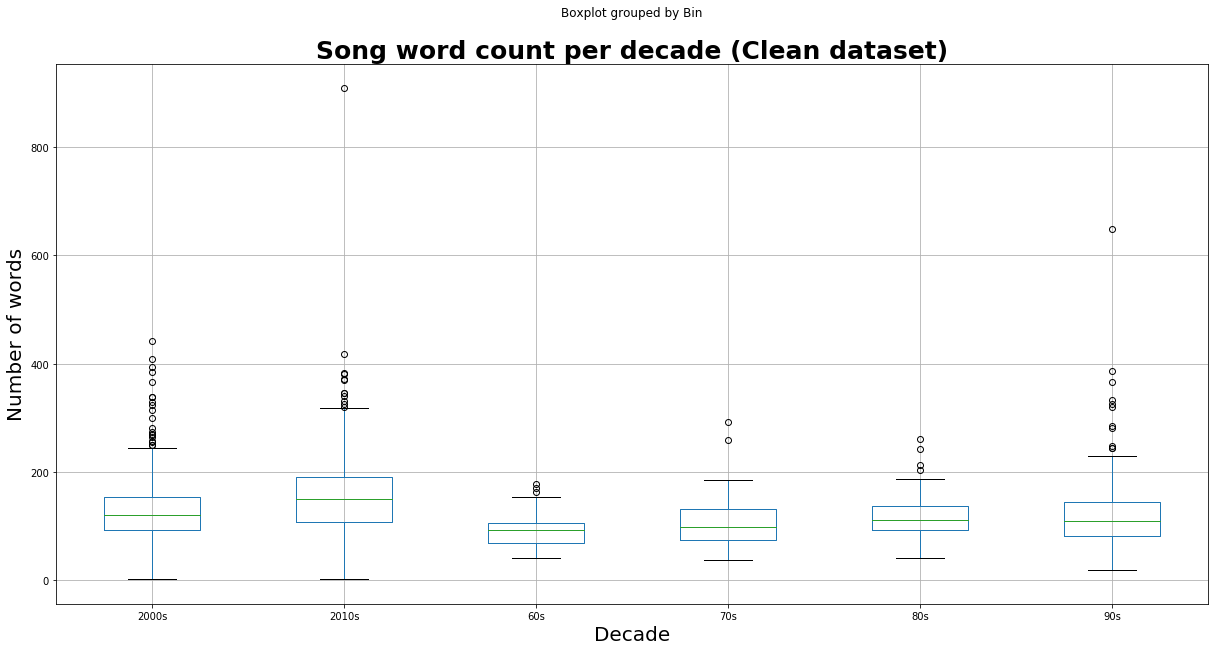

In [48]:
#Plot
words_count_clean_df.boxplot("Words count", by="Bin", figsize=(20,10))
plt.title("Song word count per decade (Clean dataset)", fontsize=25, fontweight="bold")
plt.xlabel("Decade", fontsize=20)
plt.ylabel("Number of words", fontsize=20)
plt.savefig("Plots/word_count_boxplot_clean.png")

## Check outliers: round 2

In [37]:
#Identify outliers from words_count_df with number of words >600
outliers_2=words_count_clean_df.loc[words_count_clean_df["Words count"] > 600] 
outliers_2

,Song Name,Artist,Words count,Year,Bin
551,"Love Me Like You Do - From ""Fifty Shades of Grey""",Ellie Goulding,909,2015,2010s
990,Brown Skin Lady,Black Star,648,1998,90s


In [38]:
#Retrieve info for outliers in song_list_df
outliers_2_df=song_list_df.loc[(song_list_df.index == 551) | (song_list_df.index == 990)]
outliers_2_df

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins
551,523,"Love Me Like You Do - From ""Fifty Shades of Grey""",Ellie Goulding,0,"Love Me Like You Do (From ""Fifty Shades of Grey"")",Song of the Year\nKendrick Lamar - Alright\nTa...,2015,2010s
990,704,Brown Skin Lady,Black Star,346,Mos Def & Talib Kweli Are Black Star,[Sample: Chameleon Street]\nSmooth: You got th...,1998,90s


In [39]:
#Ellie Goulding - Love Me Like You Do - From "Fifty Shades of Grey"
outliers_2_df["Lyrics"][551]

#Comment: lyrics match from Genius is list of 2016 Grammys Nominees (https://genius.com/Grammys-2016-nominees-lyrics)
# ----> DROP

'Song of the Year\nKendrick Lamar - Alright\nTaylor Swift - Blank Space\nLittle Big Town - Girl Crush\nWiz Khalifa - See You Again ft. Charlie Puth\nEd Sheeran - Thinking Out Loud - WINNER\nRecord of the Year\nD\'Angelo & The Vanguard - Really Love\nMark Ronson - Uptown Funk ft. Bruno Mars - WINNER\nEd Sheeran - Thinking Out Loud\nTaylor Swift - Blank Space\nThe Weeknd - Can\'t Feel My Face\nAlbum of the Year\nAlabama Shakes - Sound & Color\nKendrick Lamar - To Pimp A Butterfly\nChris Stapleton - Traveller\nTaylor Swift - 1989 - WINNER\nThe Weeknd - Beauty Behind The Madness\nBest New Artist\nCourtney Barnett\nJames Bay\nSam Hunt\nTori Kelly\nMeghan Trainor - WINNER\nBest Rap Performance:\nJ. Cole - "Apparently"\nDrake - "Back to Back"\nFetty Wap - "Trap Queen"\nKendrick Lamar - "Alright" - WINNER\nNicki Minaj - "Truffle Butter" ft. Drake & Lil\' Wayne\nKanye West - "All Day" ft. Theophilus London\nBest Rap/Sung Collaboration:\nBig Sean - "One Man Can Change the World" ft. Kanye West &

In [26]:
#Black Star - Brown Skin Lady"
outliers_2_df["Lyrics"][990]

#Comment: Song really has long lyrics, both members of the band (Talib Kweli and Mos Def) sing at the same time 
#(https://genius.com/Black-star-brown-skin-lady-lyrics)  ----> Could keep but it's indeed an outlier

'[Sample: Chameleon Street]\nSmooth: You got that good hair too\nWilliam Douglas Street: You like what?\nSmooth: I like girls with that light complexion on them\nStreet: You\'re a moron\nSmooth: I can\'t help it\nStreet: What? Being a moron\nSmooth: Yeah that too\nStreet: You\'re the first one out there with a dashiki talking that crap\nSmooth: I\'m a victim -\nStreet: "Good hair." Nigga you so brainwashed\nSmooth: I\'m a victim brother\nStreet: You\'re a \'victim\'\nSmooth: I\'m a victim of 400 years of conditioning\nStreet: Shut up\nSmooth: The Man has programmed my conditioning\nStreet: Mhm\nSmooth: Even my conditioning has been conditioned\n\n[Intro: Talib Kweli & Mos Def]\nBut most of yall brothers\nCame from your mothers\nLooking all sweet (Black Star keep shining)\nAnd be like yo, let me ask you somethin\nI wanna know, I wanna know who you are\n\n[Chorus: Mos Def & Talib Kweli]\nBrown skin lady, hey hey\nYes\nWhere you goin\'\nThis goes to the brown skin ladies yo\nBrown skin la

In [42]:
#Drop outliers
words_count_clean_2_df=words_count_clean_df.drop([551, 990])
words_count_clean_2_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,101,2002,2000s
1,Yellow,Coldplay,99,2000,2000s
2,Fix You,Coldplay,93,2005,2000s
3,Chasing Cars,Snow Patrol,83,2006,2000s
4,I'm Yours,Jason Mraz,227,2008,2000s
...,...,...,...,...,...
1105,Hard to Say I'm Sorry,Chicago,96,1983,80s
1106,Haunted,Taylor Swift,172,2010,2010s
1107,Breakthrough,Modest Mouse,118,1996,90s
1108,Saturday Night,Misfits,124,1999,90s


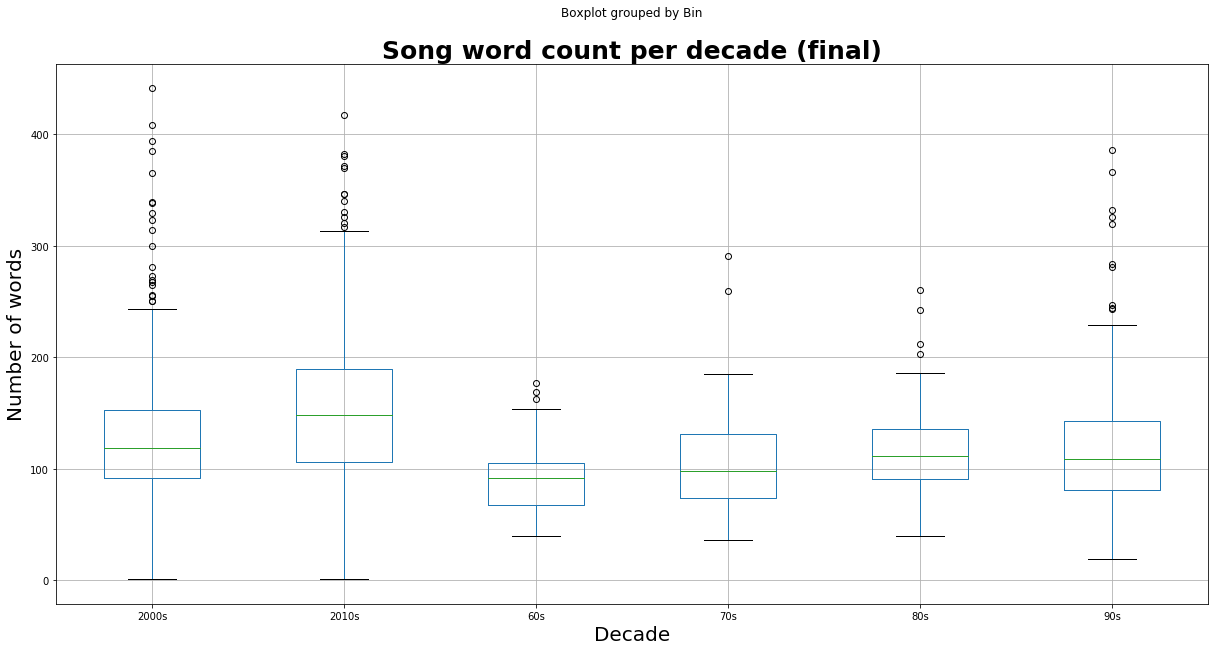

In [126]:
#Plot
words_count_clean_2_df.boxplot("Words count", by="Bin", figsize=(20,10))
plt.title("Song word count per decade (final)", fontsize=25, fontweight="bold")
plt.xlabel("Decade", fontsize=20)
plt.ylabel("Number of words", fontsize=20)
plt.savefig("Plots/word_count_boxplot_final_raw.png")

In [52]:
#Statistical analysis OneWay ANOVA

#create separate subsets per bin
words_2010s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "2010s"]["Words count"]
words_2000s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "2000s"]["Words count"]
words_90s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "90s"]["Words count"]
words_80s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "80s"]["Words count"]
words_70s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "70s"]["Words count"]
words_60s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "60s"]["Words count"]

#run OneWay ANOVA
(statistic, pvalue)=stats.f_oneway(words_2010s, words_2000s, words_90s, words_80s, words_70s, words_60s)
pvalue

1.1195819010070597e-21

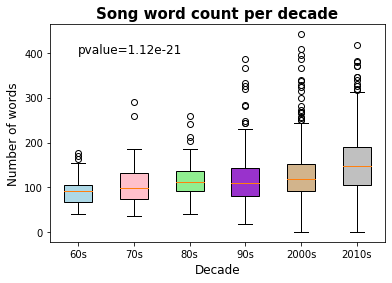

In [121]:
#PLOT USING MATPLOTLIB, CHANGE COLORS
fig= plt.plot(figsize=(40,20))
labels=["60s", "70s", "80s", "90s", "2000s", "2010s"]
data=[words_60s, words_70s,words_80s, words_90s, words_2000s, words_2010s]
# colors=["lightblue", "pink", "lightgreen", "purple", "lightorange", "grey"]

# rectangular box plot
bplot = plt.boxplot(data,patch_artist=True,  # fill with color,
                    labels=labels)  # will be used to label x-ticks

plt.title("Song word count per decade", fontsize=15, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Number of words", fontsize=12)



# fill with colors
#Note: bplot is a dict, these are the keys: ['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means']
colors=["lightblue", "pink", "lightgreen", "darkorchid", "tan", "silver"]

for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

#Annotate pvalue
string_pvalue= f'pvalue=1.12e-21'
plt.annotate(string_pvalue, (1, 400), fontsize=12, color="black")
        

plt.savefig("Plots/word_count_boxplot_final_colors.png")